In [6]:
# Importowanie niezbędnych bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.utils import resample
from scipy import stats 
import pandas as pd


In [7]:
# Wczytywanie zbioru danych, uwzględniając metodę kompresji
# df = pd.read_csv('data/dengue.csv', compression='gzip', encoding='utf-8')
df = pd.read_csv('data/dengue.csv', encoding='utf-8')

# Sprawdzenie dostępnych kolumn
print("Dostępne kolumny w zbiorze danych:", df.columns)

Dostępne kolumny w zbiorze danych: Index(['serial', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'conditions', 'stations', 'cases', 'labels'],
      dtype='object')


In [8]:
# informacje o kolumna, typach i zawartościach
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   serial            602 non-null    int64  
 1   tempmax           602 non-null    float64
 2   tempmin           602 non-null    float64
 3   temp              602 non-null    float64
 4   feelslikemax      602 non-null    float64
 5   feelslikemin      602 non-null    float64
 6   feelslike         602 non-null    float64
 7   dew               602 non-null    float64
 8   humidity          602 non-null    float64
 9   precip            602 non-null    float64
 10  precipprob        602 non-null    float64
 11  precipcover       602 non-null    float64
 12  snow              602 non-null    float64
 13  snowdepth         602 non-null    float64
 14  windspeed         602 non-null    float64
 15  winddir           602 non-null    float64
 16  sealevelpressure  602 non-null    float64
 1

# Eksploracja i wstępne przetwarzanie danych:

### Usunięcie kolumny 'serial'

In [9]:
# usuwamy kolumnę bo działa ona jedynie jako unikalny identyfikator (ID) i nie oferuje żadnych znaczących informacji o każdej obserwacji
df = df.drop(columns=['serial'])
df.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,stations,cases,labels
0,34.053151,24.478082,28.709863,39.757808,25.317808,32.306301,22.971233,73.508219,2.921726,44.657534,...,1007.911781,50.747945,3.789863,208.097808,17.973699,7.232877,2.558904,1.197260,4925.0,normal
1,34.086179,25.694309,29.464228,41.338211,28.140650,34.423577,23.484553,72.066667,3.783415,39.837398,...,1003.533333,48.313821,2.884553,222.926016,19.246341,7.504065,1.658537,0.991870,5077.0,normal
2,34.573984,25.417886,29.526829,40.464228,26.560163,33.085366,22.580488,69.424390,3.065854,33.333333,...,1005.731707,55.621138,4.242276,229.413008,19.802439,7.829268,1.910569,1.170732,7579.0,normal
3,33.020325,25.080488,28.727642,37.878049,26.193496,31.772358,21.752033,69.297561,6.025203,37.398374,...,1003.359350,50.208130,2.991057,225.421951,19.480488,7.593496,1.300813,0.146341,13706.0,normal
4,30.660976,24.230894,26.774797,36.586992,24.263415,28.943902,24.214634,86.652033,23.336585,96.747967,...,1009.995935,45.542276,3.886992,176.598374,15.261789,6.186992,0.967480,3.951220,82.0,normal


### Zaokrąglanie wartości w początkowych rekordach

In [10]:
# pierwsze 15 wpisów w zbiorze danych wydaje się mieć różne wzorce wartości w porównaniu do reszty,
# zaokrąglenie tych liczb do najbliższego drugiego miejsca po przecinku
df.iloc[:15] = df.iloc[:15].round(2)

In [11]:
# zmiana typu danych kolumny `cases` na int, przypadki nie mogą być zmienno przecinkowe
df['cases'] = df['cases'].astype(int)

In [12]:
df.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,stations,cases,labels
0,34.05,24.48,28.71,39.76,25.32,32.31,22.97,73.51,2.92,44.66,...,1007.91,50.75,3.79,208.10,17.97,7.23,2.56,1.20,4925,normal
1,34.09,25.69,29.46,41.34,28.14,34.42,23.48,72.07,3.78,39.84,...,1003.53,48.31,2.88,222.93,19.25,7.50,1.66,0.99,5077,normal
2,34.57,25.42,29.53,40.46,26.56,33.09,22.58,69.42,3.07,33.33,...,1005.73,55.62,4.24,229.41,19.80,7.83,1.91,1.17,7579,normal
3,33.02,25.08,28.73,37.88,26.19,31.77,21.75,69.30,6.03,37.40,...,1003.36,50.21,2.99,225.42,19.48,7.59,1.30,0.15,13706,normal
4,30.66,24.23,26.77,36.59,24.26,28.94,24.21,86.65,23.34,96.75,...,1010.00,45.54,3.89,176.60,15.26,6.19,0.97,3.95,82,normal


### Usunięcie kolumn nieinformacyjnych

In [13]:
#kolumny zawierające tylko pojedyncze wartości, nie dostarczają żadnych przydatnych informacji do analizy lub modelowania
df = df.drop(columns=['tempmax','tempmin','feelslikemax','feelslikemin','snow','snowdepth','labels'])
df.head()

,temp,feelslike,dew,humidity,precip,precipprob,precipcover,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,stations,cases
0,28.71,32.31,22.97,73.51,2.92,44.66,4.36,15.68,175.60,1007.91,50.75,3.79,208.10,17.97,7.23,2.56,1.20,4925
1,29.46,34.42,23.48,72.07,3.78,39.84,2.68,14.57,158.35,1003.53,48.31,2.88,222.93,19.25,7.50,1.66,0.99,5077
2,29.53,33.09,22.58,69.42,3.07,33.33,2.34,14.98,202.62,1005.73,55.62,4.24,229.41,19.80,7.83,1.91,1.17,7579
3,28.73,31.77,21.75,69.30,6.03,37.40,2.68,16.50,183.54,1003.36,50.21,2.99,225.42,19.48,7.59,1.30,0.15,13706
4,26.77,28.94,24.21,86.65,23.34,96.75,15.62,19.55,224.03,1010.00,45.54,3.89,176.60,15.26,6.19,0.97,3.95,82


### Analiza korelacji i wybór cech

In [14]:
print(df.columns)


Index(['temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'conditions',
       'stations', 'cases'],
      dtype='object')


In [15]:
# Select available columns
#corr_matrix = df[['temp', 'feelslike', 'dew', 'humidity', 'precip', 'cases']].corr()

corr_matrix = df[['temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'conditions',
       'stations', 'cases']
      ].corr()

# Print the correlation of 'cases' with other variables, sorted in descending order
print(corr_matrix['cases'].sort_values(ascending=False))


cases               1.000000
feelslike           0.415349
temp                0.378157
windspeed           0.372894
stations            0.261898
visibility          0.248551
dew                 0.179927
winddir             0.023418
precip             -0.015551
sealevelpressure   -0.016806
cloudcover         -0.189714
humidity           -0.208193
solarradiation     -0.215880
solarenergy        -0.217348
precipprob         -0.222055
uvindex            -0.225523
precipcover        -0.236217
conditions         -0.437429
Name: cases, dtype: float64


### Wybór cechy najlepiej skorelowanej ze zmienną docelową


In [16]:
best_temp_feature = corr_matrix['cases'].drop('cases').idxmax()
print(f"Najlepiej skorelowana cecha temperaturowa: {best_temp_feature}")

Najlepiej skorelowana cecha temperaturowa: feelslike


In [17]:
df.columns

Index(['temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'conditions',
       'stations', 'cases'],
      dtype='object')

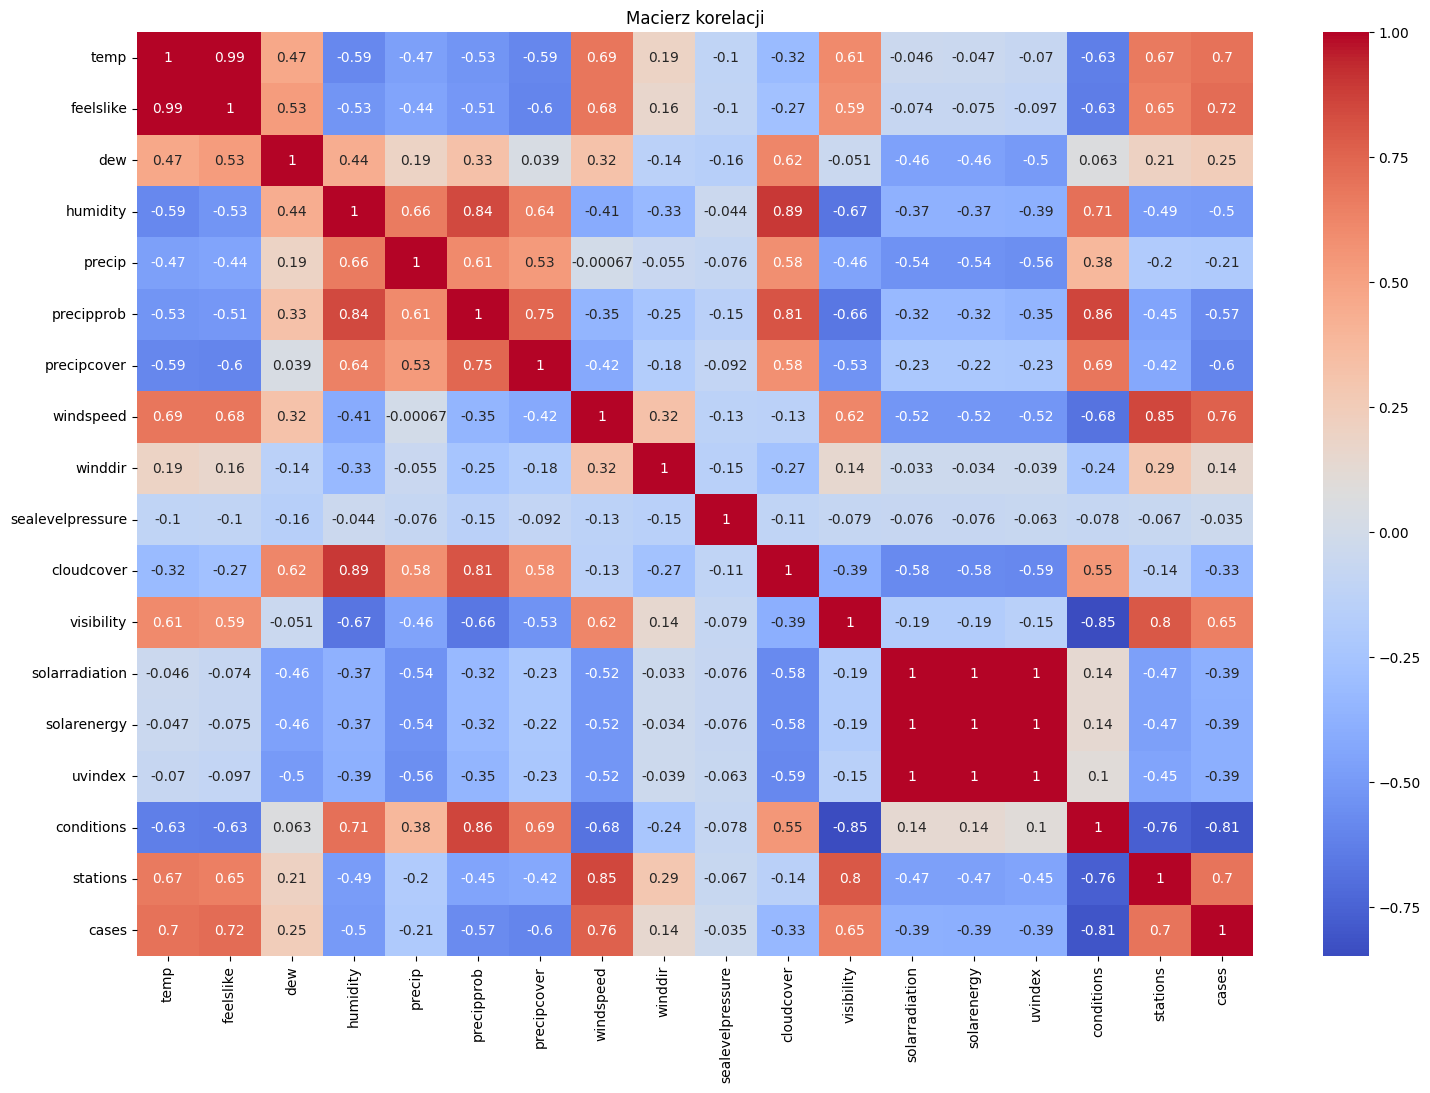

In [20]:
# Korelacja zmiennych z liczbą przypadków
plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix.corr(), annot=True, cmap='coolwarm')
plt.title("Macierz korelacji")
plt.show()

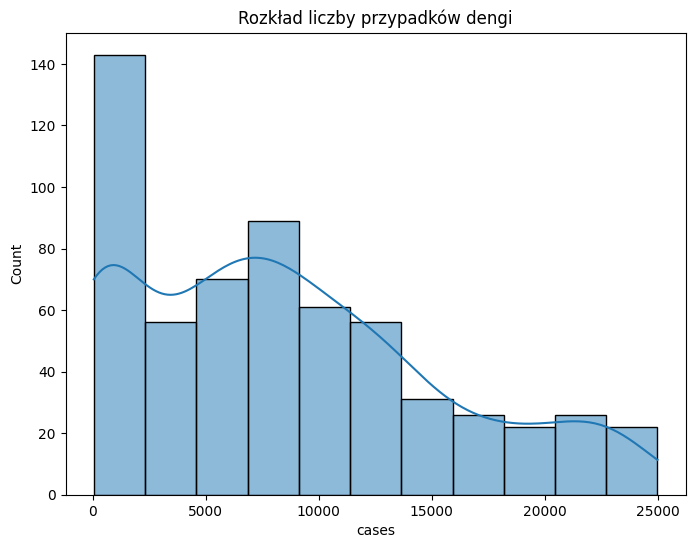

In [21]:
# Rozkład liczby przypadków
plt.figure(figsize=(8, 6))
sns.histplot(df['cases'], kde=True)
plt.title("Rozkład liczby przypadków dengi")
plt.show()

### Wybór cech do analizy (w tym najlepiej skorelowana cecha)

In [23]:
features = [best_temp_feature, 'humidity', 'precip', 'windspeed', 'solarradiation']
features

['feelslike', 'humidity', 'precip', 'windspeed', 'solarradiation']

### Dodanie nowej cechy, np. heat_index (może być obliczana jako średnia temp i humidity)

In [24]:
# połączenie temperatury i wilgotności w celu utworzenia funkcji "indeks ciepła" może zapewnić dodatkową moc predykcyjną
df['heat_index'] = (df[best_temp_feature] + df['humidity']) / 2

1. Regresja

In [25]:
# Dla regresji: Przewidywanie liczby przypadków
X_reg = df[features + ['heat_index']]  # Wybór cech
y_reg = df['cases']   # Zmienna docelowa do regresji

# Podział na zbiory treningowy i testowy
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Skalowanie cech
scaler = StandardScaler()
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)

# Budowanie modelu regresji
model_reg = LinearRegression()
model_reg.fit(X_train_reg, y_train_reg)

# Przewidywanie na zbiorze testowym
y_pred_reg = model_reg.predict(X_test_reg)

# Ocena modelu regresji
mse = mean_squared_error(y_test_reg, y_pred_reg)
print(f'Mean Squared Error (MSE) dla regresji: {mse}')


Mean Squared Error (MSE) dla regresji: 30804747.78027543


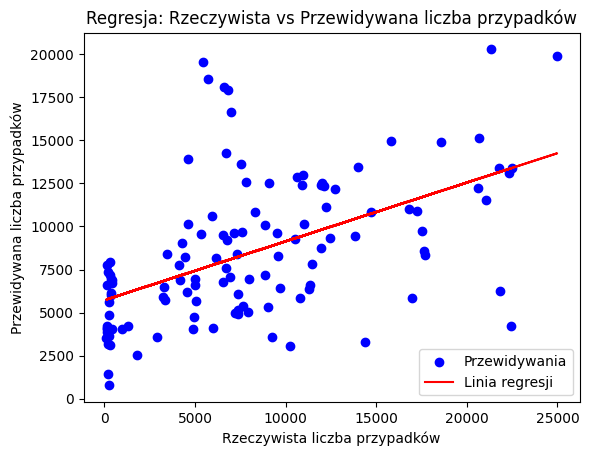

In [26]:
# Wizualizacja wyników regresji
plt.scatter(y_test_reg, y_pred_reg, color='blue', label='Przewidywania')
plt.xlabel('Rzeczywista liczba przypadków')
plt.ylabel('Przewidywana liczba przypadków')
plt.title('Regresja: Rzeczywista vs Przewidywana liczba przypadków')

# Dopasowanie prostej do wyników
z = np.polyfit(y_test_reg, y_pred_reg, 1)  # Dopasowanie prostej liniowej (stopień 1)
p = np.poly1d(z)
plt.plot(y_test_reg, p(y_test_reg), color='red', label='Linia regresji')

plt.legend()
plt.show()

2. Klasyfikacja

In [27]:
# Kategoryzowanie liczby przypadków (przykład)
bins = [0, 10, 50, 100, np.inf]  # dostosuj kategorie do swojego zbioru danych
labels = ['Niska', 'Średnia', 'Wysoka', 'Bardzo Wysoka']
df['severity'] = pd.cut(df['cases'], bins=bins, labels=labels)


# Sprawdzenie dystrybucji klas przed nadpróbkowaniem
print("Dystrybucja klas przed nadpróbkowaniem:")
print(df['severity'].value_counts())

# Sprawdzenie, czy klasa 'Niska' istnieje i jej nadpróbkowanie
if 'Niska' in df['severity'].values:
    df_minority = df[df['severity'] == 'Niska']
    df_majority = df[df['severity'] != 'Niska']

    # Nadpróbkowanie klasy mniejszościowej
    df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
else:
    print("Brak danych dla klasy 'Niska', pomijam nadpróbkowanie.")
    df_upsampled = df


Dystrybucja klas przed nadpróbkowaniem:
severity
Bardzo Wysoka    582
Wysoka            20
Niska              0
Średnia            0
Name: count, dtype: int64
Brak danych dla klasy 'Niska', pomijam nadpróbkowanie.


In [28]:
# Wybór cech do klasyfikacji
X_clf = df_upsampled[features + ['heat_index']]
y_clf = df_upsampled['severity']

# Podział na zbiory treningowy i testowy
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Skalowanie cech
X_train_clf = scaler.fit_transform(X_train_clf)
X_test_clf = scaler.transform(X_test_clf)

# Budowanie modelu klasyfikacji
model_clf = RandomForestClassifier(random_state=42)
model_clf.fit(X_train_clf, y_train_clf)

# Przewidywanie na zbiorze testowym
y_pred_clf = model_clf.predict(X_test_clf)

In [29]:
# Ocena modelu klasyfikacji
print(classification_report(y_test_clf, y_pred_clf, zero_division=0))

               precision    recall  f1-score   support

Bardzo Wysoka       0.99      1.00      1.00       120
       Wysoka       0.00      0.00      0.00         1

     accuracy                           0.99       121
    macro avg       0.50      0.50      0.50       121
 weighted avg       0.98      0.99      0.99       121



## Wizaualizacja macierzy pomyłek dla klasyfikacji

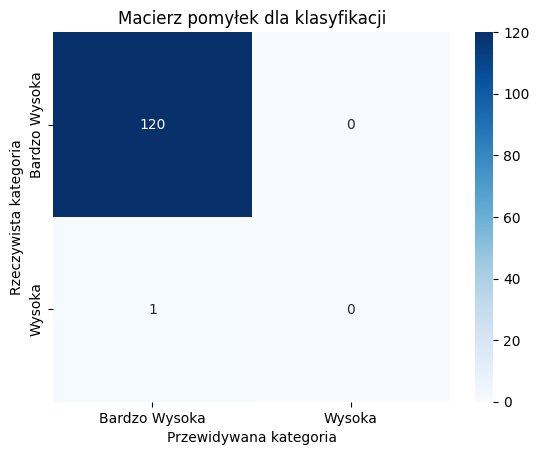

In [30]:
cm = confusion_matrix(y_test_clf, y_pred_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_clf.classes_, yticklabels=model_clf.classes_)
plt.xlabel('Przewidywana kategoria')
plt.ylabel('Rzeczywista kategoria')
plt.title('Macierz pomyłek dla klasyfikacji')
plt.show()

# Wizualizacja rozkładów cech

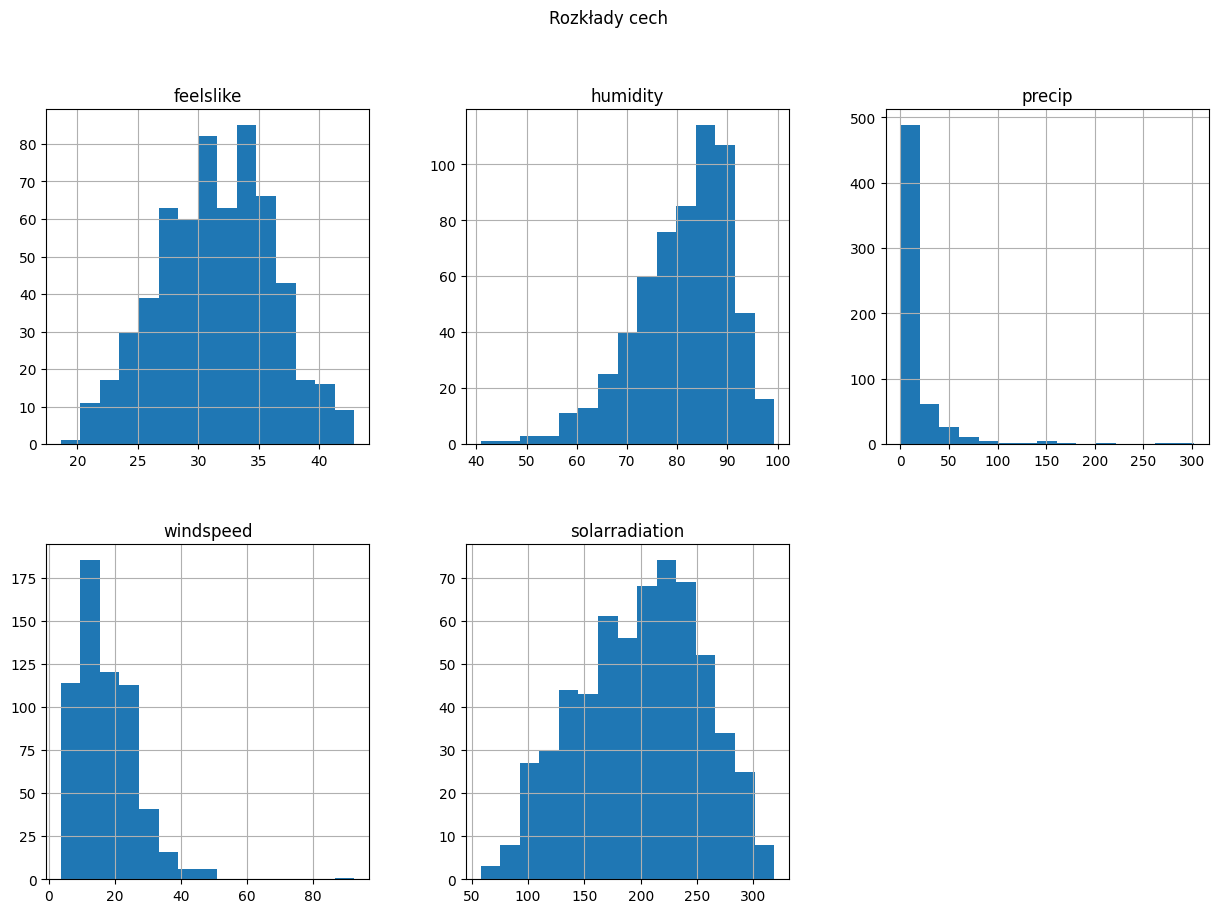

In [31]:
df[features].hist(bins=15, figsize=(15, 10), layout=(2, 3))
plt.suptitle('Rozkłady cech')
plt.show()

# Wykresy pudełkowe (Box plots) dla cech

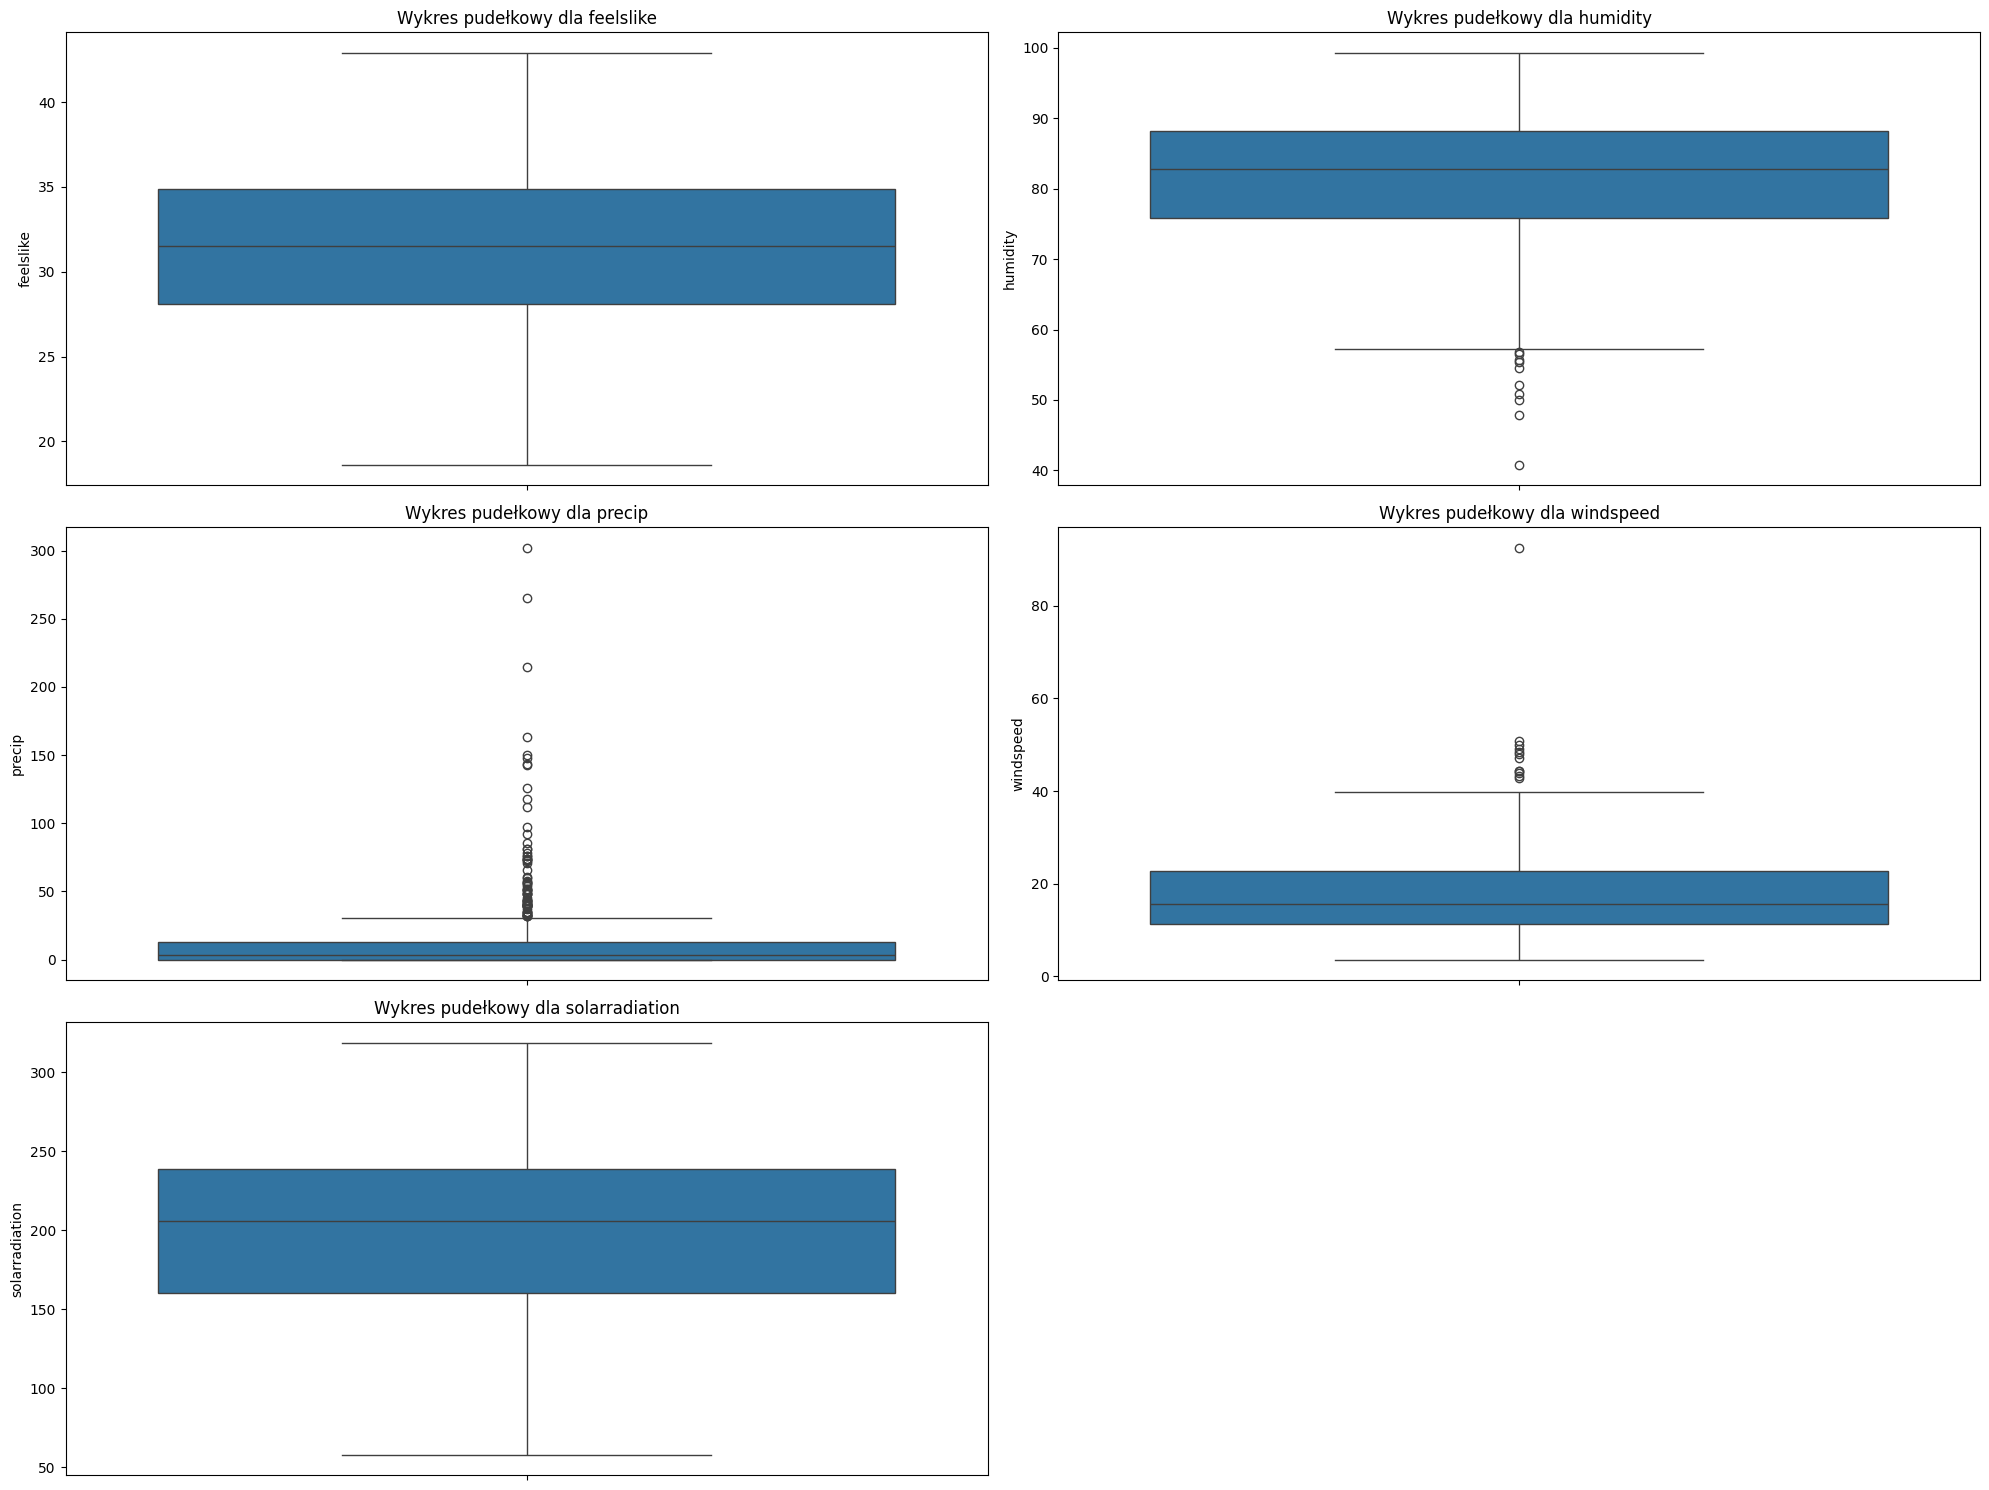

In [32]:
# Lista cech do przedstawienia na oddzielnych wykresach
features = ['feelslike', 'humidity', 'precip', 'windspeed', 'solarradiation']

# Ustawienie wielkości całej figury (rysunku)
plt.figure(figsize=(20, 15))

# Tworzenie oddzielnych wykresów pudełkowych dla każdej cechy
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)  # Tworzenie siatki 3x2 dla wykresów
    sns.boxplot(data=df[feature])
    plt.title(f'Wykres pudełkowy dla {feature}')

plt.tight_layout()  # Poprawia odstępy między wykresami
plt.show()


# Macierz korelacji

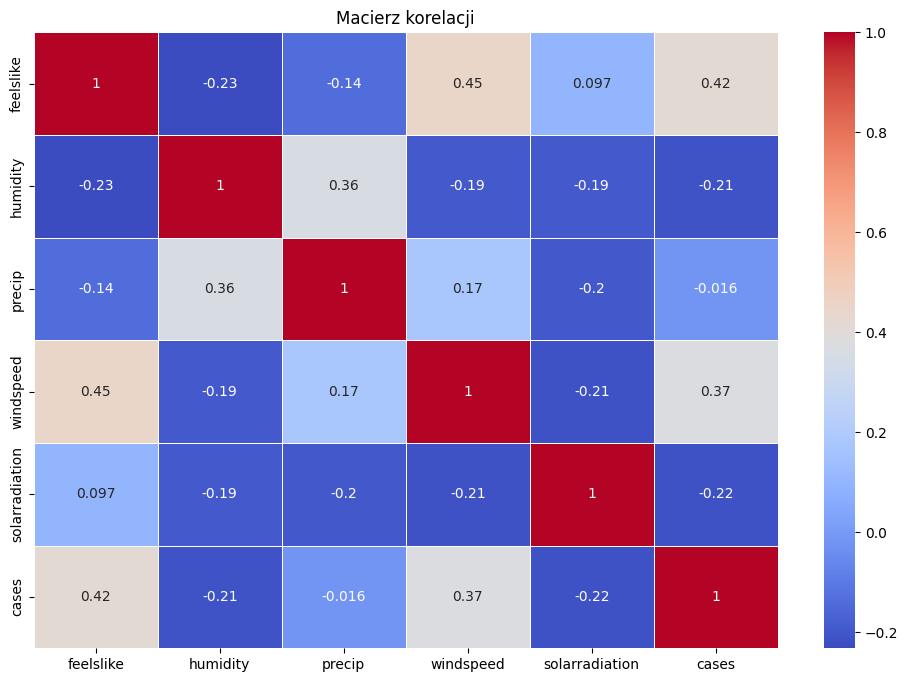

In [33]:
plt.figure(figsize=(12, 8))
correlation_matrix = df[features + ['cases']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Macierz korelacji')
plt.show()


# Relacja między cechami a zmienną docelową (liczba przypadków)

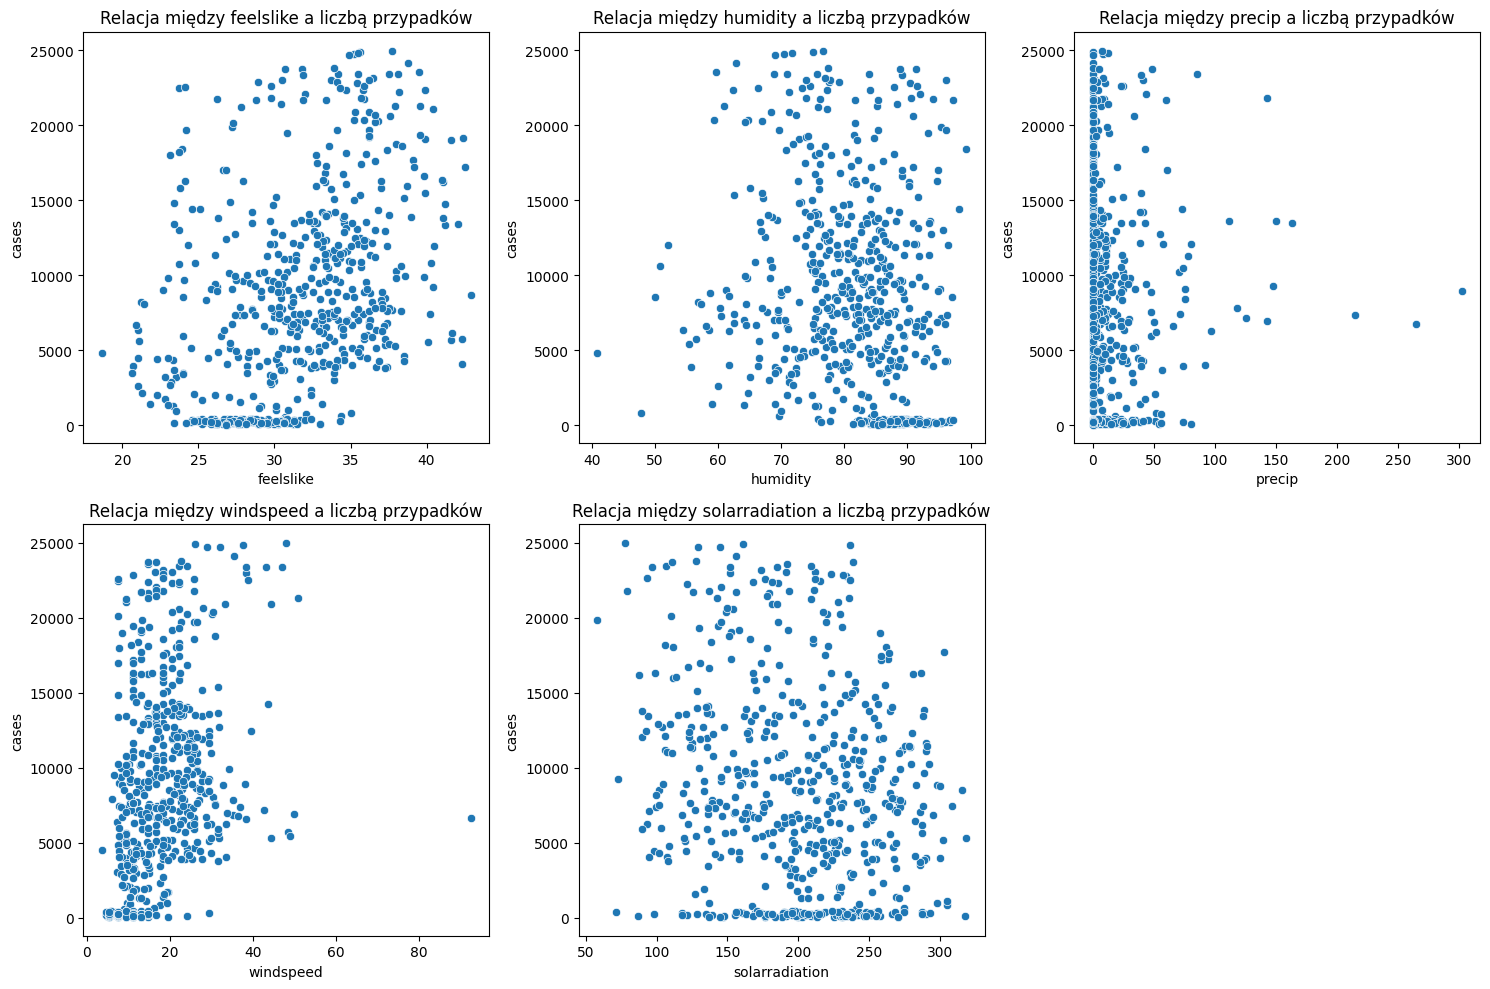

In [35]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(x=df[feature], y=df['cases'])
    plt.title(f'Relacja między {feature} a liczbą przypadków')

plt.tight_layout()
plt.show()

# Identyfikacja wartości odstających (outliers) dla 'cases'

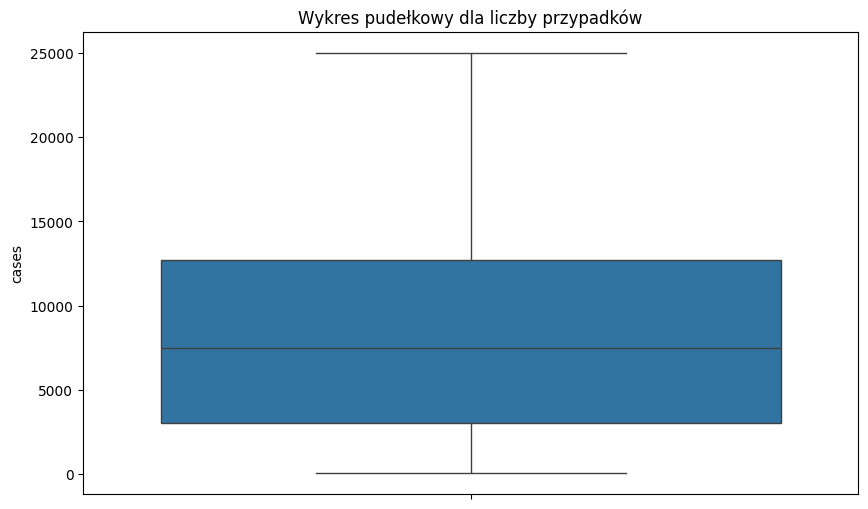

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(df['cases'])
plt.title('Wykres pudełkowy dla liczby przypadków')
plt.show()

### Weryfikacja anomalii i radzenie sobie z błędnymi wartościami
> Przykład: Sprawdzanie anomalii w kolumnie 'sealevelpressure'

In [37]:
if 'sealevelpressure' in df.columns:
    print("Liczba wierszy z 'sealevelpressure' równym 0:", (df['sealevelpressure'] == 0).sum())
    
    # Zakładamy, że 0 oznacza brak danych - w takim przypadku imputujemy medianę
    df['sealevelpressure'] = df['sealevelpressure'].replace(0, np.nan)
    df['sealevelpressure'] = df['sealevelpressure'].fillna(df['sealevelpressure'].median())


Liczba wierszy z 'sealevelpressure' równym 0: 1


### Wykrywanie wartości odstających i ekstremalnych
> Przykład: Analiza zmiennych numerycznych, np. 'precip' (opady)

In [38]:
numeric_columns = [
    'tempmax', 'tempmin', 'temp', 
    'feelslikemax', 'feelslikemin', 'feelslike', 
    'humidity', 'precip', 'windspeed', 'solarradiation'
    ]

### Wykrywanie wartości odstających za pomocą Z-score

In [39]:
# wybór kolumn numerycznych, które istnieją w DataFrame
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# obliczenie wyników Z-scores dla dostępnych kolumn numerycznych
z_scores = np.abs(stats.zscore(df[numeric_columns]))

# znalezienie wierszy, w których którykolwiek ze współczynników Z-scores przekracza 3 (wartości odstające)
outliers = (z_scores > 3).sum(axis=1)

# wyświetlenie liczby wierszy z wartościami odstającymi
print("Liczba wierszy z wartościami odstającymi (Z-score > 3):", (outliers > 0).sum())


Liczba wierszy z wartościami odstającymi (Z-score > 3): 65


In [40]:
z_scores = np.abs(stats.zscore(df[numeric_columns]))
outliers = (z_scores > 3).sum(axis=1)

print("Liczba wierszy z wartościami odstającymi (Z-score > 3):", (outliers > 0).sum())


Liczba wierszy z wartościami odstającymi (Z-score > 3): 65


In [41]:
# Przykład: wybór kolumn numerycznych
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Obliczanie Z-score dla każdej kolumny numerycznej
z_scores = np.abs(stats.zscore(df[numeric_columns]))

# Znalezienie wartości odstających (Z-score > 3)
outliers_mask = (z_scores > 3)

# Wyświetlenie wierszy, które mają wartości odstające
outliers = df[outliers_mask.any(axis=1)]

# Wypisanie wierszy z wartościami odstającymi
print("Wiersze z wartościami odstającymi (Z-score > 3):")
print(outliers)

Wiersze z wartościami odstającymi (Z-score > 3):
      temp  feelslike    dew  humidity  precip  precipprob  precipcover  \
4    26.77      28.94  24.21     86.65   23.34       96.75        15.62   
13   24.80      25.26  19.31     72.65    0.41       14.29         4.72   
14   18.82      18.63   4.48     40.83    0.01        4.44         0.28   
15   32.90      35.20  19.70     50.00    2.30      100.00        37.50   
16   33.30      35.00  18.80     47.80   52.00      100.00         4.17   
..     ...        ...    ...       ...     ...         ...          ...   
543  26.50      28.50  25.30     93.40  163.00      100.00        29.17   
544  25.80      26.20  24.90     94.80  302.00      100.00        33.33   
558  27.40      31.10  25.80     91.40   66.00      100.00        16.67   
585  31.70      34.20  20.30     52.10    0.00        0.00         0.00   
586  31.30      33.40  19.60     50.80    0.00        0.00         0.00   

     windspeed  winddir  sealevelpressure  cloudco

# Przykład strategii zarządzania wartościami odstającymi:
1. Przekształcenia logarytmiczne dla 'precip'

In [42]:
df['precip_log'] = np.log1p(df['precip'])
df['precip_log'] 

0      1.366092
1      1.564441
2      1.403643
3      1.950187
4      3.192121
         ...   
597    0.000000
598    0.000000
599    0.000000
600    0.000000
601    0.000000
Name: precip_log, Length: 602, dtype: float64

2. Binning dla 'windspeed'

In [43]:
df['windspeed_binned'] = pd.cut(df['windspeed'], bins=5, labels=False)
df['windspeed_binned']

0      0
1      0
2      0
3      0
4      0
      ..
597    0
598    0
599    0
600    0
601    0
Name: windspeed_binned, Length: 602, dtype: int64

3. Ograniczanie (capping) wartości odstających dla 'humidity'

In [44]:
q_low = df['humidity'].quantile(0.01)
q_high = df['humidity'].quantile(0.99)
df['humidity_capped'] = np.clip(df['humidity'], q_low, q_high)
df['humidity_capped'] 

0      73.51
1      72.07
2      69.42
3      69.30
4      86.65
       ...  
597    75.00
598    68.50
599    71.10
600    65.90
601    60.40
Name: humidity_capped, Length: 602, dtype: float64

### Wizualizacja wpływu przekształceń na wartości odstające

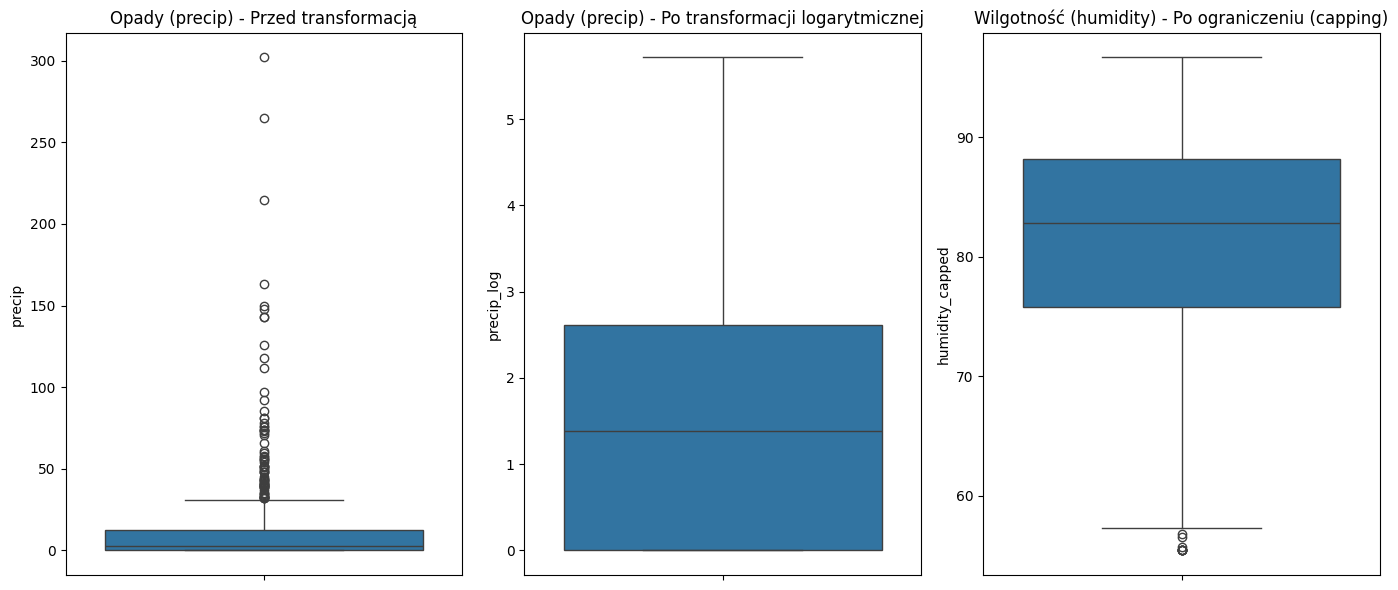

In [45]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.boxplot(y=df['precip'])
plt.title('Opady (precip) - Przed transformacją')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['precip_log'])
plt.title('Opady (precip) - Po transformacji logarytmicznej')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['humidity_capped'])
plt.title('Wilgotność (humidity) - Po ograniczeniu (capping)')

plt.tight_layout()
plt.show()

# Rozwoj modelu

In [46]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler


In [48]:
# Wczytywanie zbioru danych
# df = pd.read_csv('data/dengue.csv', compression='gzip')
df = pd.read_csv('data/dengue.csv')

# Sprawdzenie dostępnych kolumn
print(df.columns)

Index(['serial', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'conditions', 'stations', 'cases', 'labels'],
      dtype='object')


### Wybór kolumn do analizy

In [49]:
features = ['temp', 'humidity', 'precip', 'windspeed', 'solarradiation']
X = df[features]

### Przygotowanie zmiennej docelowej do regresji (zakładamy, że 'cases' jest zmienną do przewidywania)

In [50]:
y_reg = df['cases']

In [114]:
# Sprawdzenie, czy jest kolumna do klasyfikacji
# Użyj odpowiedniej kolumny dla klasyfikacji, np. 'labels' (jeśli to etykiety klas)
# y_class = df['labels'] 

# Podział na zbiory treningowy i testowy

In [51]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Skalowanie cech

In [52]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Regresja

1. Linear Regression


In [53]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train_reg)
y_pred_reg_lin = lin_reg.predict(X_test)
print("Linear Regression MSE:", mean_squared_error(y_test_reg, y_pred_reg_lin))

Linear Regression MSE: 33751804.67489912



2. Decision Tree Regressor

In [54]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train_reg)
y_pred_reg_tree = tree_reg.predict(X_test)
print("Decision Tree Regressor MSE:", mean_squared_error(y_test_reg, y_pred_reg_tree))

Decision Tree Regressor MSE: 52478899.97520661


3. Random Forest Regressor

In [55]:
random_forest_reg = RandomForestRegressor(random_state=42)
random_forest_reg.fit(X_train, y_train_reg)
y_pred_reg_rf = random_forest_reg.predict(X_test)
print("Random Forest Regressor MSE:", mean_squared_error(y_test_reg, y_pred_reg_rf))

Random Forest Regressor MSE: 29007256.634060327


4. Neural Network Regressor

In [56]:
model_nn_reg = Sequential()
model_nn_reg.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model_nn_reg.add(Dense(32, activation='relu'))
model_nn_reg.add(Dense(1))
model_nn_reg.compile(optimizer=Adam(), loss='mean_squared_error')

history_reg = model_nn_reg.fit(X_train, y_train_reg, epochs=20, batch_size=32, validation_split=0.1, verbose=1)
y_pred_reg_nn = model_nn_reg.predict(X_test)
print("Neural Network Regressor MSE:", mean_squared_error(y_test_reg, y_pred_reg_nn))

Epoch 1/20


c:\Users\Misiek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 120081400.0000 - val_loss: 133338800.0000
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 119557528.0000 - val_loss: 133328208.0000
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 123471680.0000 - val_loss: 133312512.0000
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 125868152.0000 - val_loss: 133289632.0000
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 106209800.0000 - val_loss: 133256968.0000
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 123622640.0000 - val_loss: 133210304.0000
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 119944952.0000 - val_loss: 133145808.0000
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 117144976.0000 - val_loss: 133062080.0000
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 124150968.0000 - val_loss: 132950472.0000
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 113390016.0000 - val_loss: 132810144.0000
Epoch 11/

### Porównanie Modeli

In [57]:
results = {
    'Model': ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'Neural Network Regressor'],
    'MSE': [mean_squared_error(y_test_reg, y_pred_reg_lin),
            mean_squared_error(y_test_reg, y_pred_reg_tree),
            mean_squared_error(y_test_reg, y_pred_reg_rf),
            mean_squared_error(y_test_reg, y_pred_reg_nn)],
    'RMSE': [np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_lin)),
             np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_tree)),
             np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_rf)),
             np.sqrt(mean_squared_error(y_test_reg, y_pred_reg_nn))]
}

results_df = pd.DataFrame(results)
print(results_df)

                      Model           MSE         RMSE
0         Linear Regression  3.375180e+07  5809.630339
1   Decision Tree Regressor  5.247890e+07  7244.232187
2   Random Forest Regressor  2.900726e+07  5385.838527
3  Neural Network Regressor  9.965014e+07  9982.491450


### Uzupełnienie o Metryki

In [58]:
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score, 
                             accuracy_score, f1_score, precision_score, recall_score, 
                             cohen_kappa_score, roc_auc_score, log_loss)

# Metryki regresji
# RMSE
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print(f'Root Mean Squared Error (RMSE) dla regresji: {rmse}')

# MAE
mae = mean_absolute_error(y_test_reg, y_pred_reg)
print(f'Mean Absolute Error (MAE) dla regresji: {mae}')

# R-squared
r2 = r2_score(y_test_reg, y_pred_reg)
print(f'R-squared (R^2) dla regresji: {r2}')

# MSE
mse = mean_squared_error(y_test_reg, y_pred_reg)
print(f'Mean Squared Error (MSE) dla regresji: {mse}')

# MAPE
mape = np.mean(np.abs((y_test_reg - y_pred_reg) / y_test_reg)) * 100
print(f'Mean Absolute Percentage Error (MAPE) dla regresji: {mape}%')

Root Mean Squared Error (RMSE) dla regresji: 5550.202499033295
Mean Absolute Error (MAE) dla regresji: 4339.97088266124
R-squared (R^2) dla regresji: 0.2587383371842936
Mean Squared Error (MSE) dla regresji: 30804747.78027543
Mean Absolute Percentage Error (MAPE) dla regresji: 497.80340439631743%


# Klasyfikacja

In [59]:
df['labels']= \
np.where(df['cases'] < 3000, 'low',
np.where(df['cases'] < 13000, 'Medium', 'High')         
         ) 

In [60]:
from sklearn.svm import  LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split as TTS

In [61]:
print(df.columns)


Index(['serial', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'conditions', 'stations', 'cases', 'labels'],
      dtype='object')


In [62]:
columns_to_drop = ['cases', 'labels']
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
x = df.drop(existing_columns_to_drop, axis=1)


In [63]:
x = df.drop(['cases','labels'],axis=1)
y= df['labels']

X_train, X_test, y_train_reg, y_test_reg = TTS(X,y,test_size=0.2,stratify=y, random_state=42)

In [64]:
cls = LinearSVC()
cls.fit(X_train,y_train_clf)

cls.score(X_test,y_test_clf)

0.9917355371900827

### Random Forest Classifier

In [65]:
cf = RandomForestClassifier()
cf.fit(X_train,y_train_clf)

cf.score(X_test,y_test_clf)

0.9917355371900827

In [66]:
y_pred_cls = cls.predict(X_test)
y_pred_cf = cf.predict(X_test)

In [67]:
df.labels.unique().tolist()

['Medium', 'High', 'low']

### Uzupełnienie o Metryki

In [68]:
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score, 
                             accuracy_score, f1_score, precision_score, recall_score, 
                             cohen_kappa_score, roc_auc_score, log_loss)


# Metryki klasyfikacji
# Accuracy
accuracy = accuracy_score(y_test_clf, y_pred_clf)
print(f'Accuracy dla klasyfikacji: {accuracy}')

# F1-score
f1 = f1_score(y_test_clf, y_pred_clf, average='weighted')
print(f'F1-score dla klasyfikacji: {f1}')

# Precision
precision = precision_score(y_test_clf, y_pred_clf, average='weighted', zero_division=0)
print(f'Precision dla klasyfikacji: {precision}')

# Recall
recall = recall_score(y_test_clf, y_pred_clf, average='weighted', zero_division=0)
print(f'Recall dla klasyfikacji: {recall}')

# Cohen's Kappa
kappa = cohen_kappa_score(y_test_clf, y_pred_clf)
print(f'Cohen\'s Kappa dla klasyfikacji: {kappa}')

# ROC AUC (tylko dla problemów binarnych)
# Zakładamy, że y_test_clf i y_pred_clf mają postać binarną
# y_test_clf_proba = model_clf.predict_proba(X_test_clf)[:, 1]
# roc_auc = roc_auc_score(y_test_clf, y_test_clf_proba)
# print(f'ROC AUC dla klasyfikacji: {roc_auc}')

# Log Loss (tylko dla problemów binarnych)
# log_loss_value = log_loss(y_test_clf, y_test_clf_proba)
# print(f'Log Loss dla klasyfikacji: {log_loss_value}')


Accuracy dla klasyfikacji: 0.9917355371900827
F1-score dla klasyfikacji: 0.9876204519735263
Precision dla klasyfikacji: 0.9835393757257018
Recall dla klasyfikacji: 0.9917355371900827
Cohen's Kappa dla klasyfikacji: 0.0


### Analiza Krzywych ROC i AUC

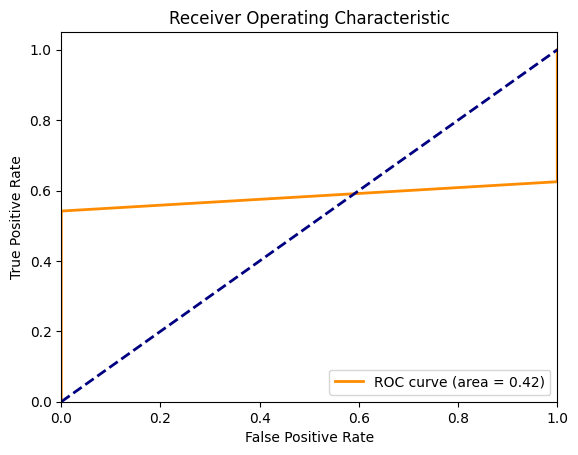

In [69]:
from sklearn.metrics import roc_curve, roc_auc_score

# Krzywa ROC i AUC
fpr, tpr, _ = roc_curve(y_test_clf, model_clf.predict_proba(X_test_clf)[:, 1], pos_label='Bardzo Wysoka')
roc_auc = roc_auc_score(y_test_clf, model_clf.predict_proba(X_test_clf)[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Walidacja Krzyżowa

In [70]:
from sklearn.model_selection import cross_val_score

# Walidacja krzyżowa dla regresji
cv_scores_reg = cross_val_score(model_reg, X_reg, y_reg, cv=5, scoring='neg_mean_squared_error')
print(f'CV Mean Squared Error: {-np.mean(cv_scores_reg)}')

# Walidacja krzyżowa dla klasyfikacji
cv_scores_clf = cross_val_score(model_clf, X_clf, y_clf, cv=5, scoring='accuracy')
print(f'CV Accuracy: {np.mean(cv_scores_clf)}')

CV Mean Squared Error: 45964129.16500519
CV Accuracy: 0.9403305785123968


### Strojenie Hiperparametrów

In [71]:
from sklearn.model_selection import GridSearchCV

# Strojenie hiperparametrów dla Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30]
}
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_clf, y_train_clf)
print("Najlepsze parametry dla Random Forest:", grid_search.best_params_)
print("Najlepszy wynik w walidacji krzyżowej:", grid_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Najlepsze parametry dla Random Forest: {'max_depth': 10, 'n_estimators': 50}
Najlepszy wynik w walidacji krzyżowej: 0.956335910652921
